# ANALISIS DE DADES:

En aquesta practica analitzarem un dataset que classifica les webs segons la categoria a la qual pertanyen.

A continuació mostrarem les llibreries necessaries per aquest treball i la informació de la base de dades:

In [3]:
#http://www.kaggle.com/hetulmehta/website-classification

from sklearn.datasets import make_regression
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats
from scipy.stats import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from IPython.display import display

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV

from wordcloud import WordCloud, STOPWORDS
from time import time

# Carreguem el dataset:
dataset = pd.read_csv('../data/website_classification.csv', header=0, delimiter=',')
data = dataset.values

dataset

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel
...,...,...,...,...
1403,1403,http://www.oldwomen.org/,old nude women porn mature granny sex horny ol...,Adult
1404,1404,http://www.webcamslave.com,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult
1405,1405,http://www.buyeuroporn.com/,porno dvd online european porn dvd cheap adult...,Adult
1406,1406,http://www.analdreamhouse.com/30/03/agecheck/i...,anal dream house anal dream house anal dream h...,Adult


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            1408 non-null   int64 
 1   website_url           1408 non-null   object
 2   cleaned_website_text  1408 non-null   object
 3   Category              1408 non-null   object
dtypes: int64(1), object(3)
memory usage: 44.1+ KB


In [5]:
pd.DataFrame(dataset.Category.unique()).values

array([['Travel'],
       ['Social Networking and Messaging'],
       ['News'],
       ['Streaming Services'],
       ['Sports'],
       ['Photography'],
       ['Law and Government'],
       ['Health and Fitness'],
       ['Games'],
       ['E-Commerce'],
       ['Forums'],
       ['Food'],
       ['Education'],
       ['Computers and Technology'],
       ['Business/Corporate'],
       ['Adult']], dtype=object)

## DESCRIPCIÓ:

- Aquest dataset conté una llista de pàgines web on cadascuna està classificada segons la categoria a la que pertany.
- En concret, conté 1408 entrades/dades (files) i 4 atributs (col·lumnes).
- Els atributs: un d'ells es l'índex numéric ("Unnamed: 0") i els altres 3 son de tipus object ("website_url", "cleaned_website_text", i "Category").
- L'atribut target o objectiu es el "Category" ja que voldrem predir la categoria a la qual pertanyen les pàgines web.
- No conté valors nuls en cap atribut, per tant no haurem de tractar-los.
- Com no tenim dades numériques (tret del index) tampoc podem treure outliers ni fer normalitzacions.

### LLISTA D'ATRIBUTS:
- 0: Unnamed: 0 ->           indica l'índex de la fila (pàgina web): [0,1,2,3,4...].
- 1: website_url ->          conté la URL de cada pàgina. És única: [www.algo.org, www.mosca.es...].
- 2: cleaned_website_text -> conté la llista de les paraules clau de la pàgina, i les podrem fer servir per estudiar a quina categoria pertanyen: [official site, good, hotel, vacation...].
- 3: Category ->             té les categories de totes les pàgines web: [Adult, Travel...]. És el atribut objectiu.

In [6]:
# Eliminem l'atribut index "Unnamed: 0" ja que no ens està aportant res.
df = dataset.drop('Unnamed: 0', axis=1)
df.head()

,website_url,cleaned_website_text,Category
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [7]:
# Eliminem les webs repetides:
df = df.drop_duplicates(subset='website_url').reset_index(drop=True)
df.shape

(1384, 3)

In [8]:
# Creem un atribut "cat_id" que contindrà la id de la categoria. Ens serà útil per a que el model entengui les diferencies.
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates()

# Diccionari de categoria amb el seu id:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

df.head()

,website_url,cleaned_website_text,Category,category_id
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0


In [9]:
category_to_id

{'Travel': 0,
 'Social Networking and Messaging': 1,
 'News': 2,
 'Streaming Services': 3,
 'Sports': 4,
 'Photography': 5,
 'Law and Government': 6,
 'Health and Fitness': 7,
 'Games': 8,
 'E-Commerce': 9,
 'Forums': 10,
 'Food': 11,
 'Education': 12,
 'Computers and Technology': 13,
 'Business/Corporate': 14,
 'Adult': 15}

In [10]:
id_to_category

{0: 'Travel',
 1: 'Social Networking and Messaging',
 2: 'News',
 3: 'Streaming Services',
 4: 'Sports',
 5: 'Photography',
 6: 'Law and Government',
 7: 'Health and Fitness',
 8: 'Games',
 9: 'E-Commerce',
 10: 'Forums',
 11: 'Food',
 12: 'Education',
 13: 'Computers and Technology',
 14: 'Business/Corporate',
 15: 'Adult'}

In [11]:
category_id_df

,Category,category_id
0,Travel,0
36,Social Networking and Messaging,1
43,News,2
107,Streaming Services,3
212,Sports,4
390,Photography,5
575,Law and Government,6
658,Health and Fitness,7
748,Games,8
790,E-Commerce,9


Hem eliminat el atribut 'Unnamed: 0' que no ens aporta res i hem afegit el 'category_id' per donar un id numèric a la categoria.

A continuació mostrem un gràfic de les webs que tenim per cada categoria:

<IPython.core.display.Javascript object>


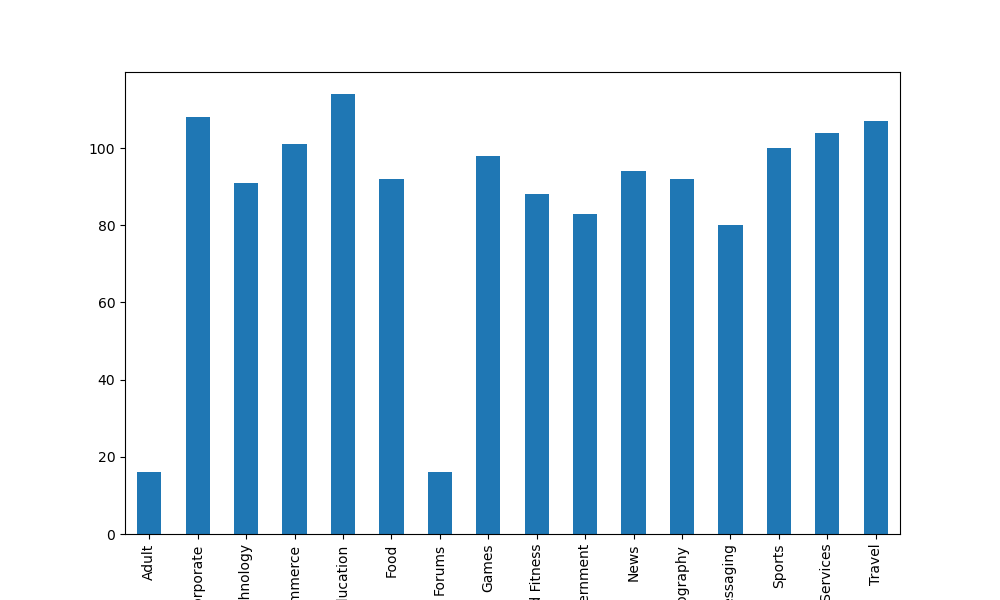

In [12]:
# Ordenem el dataset segons les categories:
df = df.sort_values(by='Category',ascending=True)

# Mostrem el numero de webs per a cada classe:
fig = plt.figure(figsize=(10,6))
df.groupby('Category').cleaned_website_text.count().plot.bar()
plt.show()

Ara veurem el WORDCLOUD de totes les categories amb les paraules que més s'han utilitzat

## PREPROCESSING:
Les dades de les que disposem son paraules, però els nostres algoritmes y classificadors d'aprenentatge no poden processar dades de text directament, esperem millor dades numèriques.
Per a preprocessar les dades transformarem les nostres dades de text en números, tenint en compte la freqüéncia en la que surten les paraules. 
Concretament, calcularem una mesura que es diu Frequència de Termes i Frequència de dades inversa:

In [13]:
# Frequència de Termes i Frequència de dades inversa = tf-idf.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=6, ngram_range=(1, 2), stop_words='english', norm='l2') # UNIGRAMS
# PROBAR AMB UNIGRAMES I BIGRAMES PER SEPARAT...

# Transformem el cleaned_text a un vector
features = tfidf.fit_transform(df.cleaned_website_text).toarray()
labels = df.category_id

print("Les %d dades de text es representen per %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))
features.shape

Les 1384 dades de text es representen per 14553 features (TF-IDF score of unigrams and bigrams)


(1384, 14553)

In [14]:
features

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05047521, 0.05743745,
        0.04445292]])

In [15]:
labels

1383    15
1368    15
1369    15
1370    15
1371    15
        ..
76       0
77       0
79       0
67       0
0        0
Name: category_id, Length: 1384, dtype: int64